In [2]:
import sklearn
import torch

In [3]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
len(X), len(y)

(1000, 1000)

In [6]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [7]:
y[:5]

array([1, 1, 1, 1, 0])

In [8]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1],
                      "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


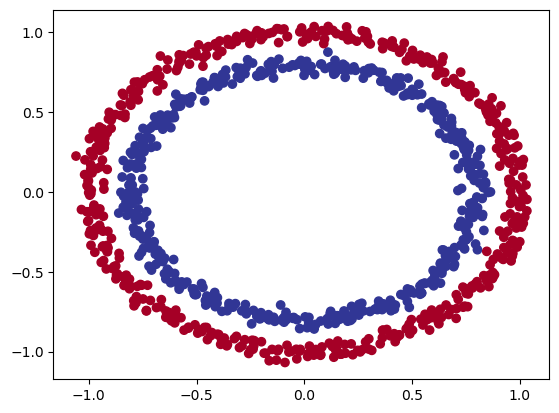

In [9]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building Model

In [13]:
from torch import nn

In [14]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
untrained_preds = model_0(X_test.to(device))

In [17]:

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [18]:
y_logits = model_0(X_test.to(device))

In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [20]:

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[-0.5326],
        [-0.4315],
        [-0.5197],
        [-0.5374],
        [-0.0785]])

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [22]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3699],
        [0.3938],
        [0.3729],
        [0.3688],
        [0.4804]])

In [23]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

In [24]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))
  
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.71221, Accuracy: 41.38% | Test loss: 0.71194
Epoch: 10 | Loss: 0.70294, Accuracy: 48.12% | Test loss: 0.70426
Epoch: 20 | Loss: 0.69936, Accuracy: 50.00% | Test loss: 0.70128
Epoch: 30 | Loss: 0.69756, Accuracy: 49.75% | Test loss: 0.69968
Epoch: 40 | Loss: 0.69646, Accuracy: 49.50% | Test loss: 0.69860
Epoch: 50 | Loss: 0.69568, Accuracy: 49.00% | Test loss: 0.69779
Epoch: 60 | Loss: 0.69510, Accuracy: 49.25% | Test loss: 0.69714
Epoch: 70 | Loss: 0.69466, Accuracy: 49.12% | Test loss: 0.69662
Epoch: 80 | Loss: 0.69432, Accuracy: 49.62% | Test loss: 0.69620
Epoch: 90 | Loss: 0.69405, Accuracy: 49.88% | Test loss: 0.69586


In [25]:
import requests
from pathlib import Path

if Path("Helper_functions.py").is_file():
    print("Already Exists!")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

Already Exists!


In [26]:
from helper_functions import plot_predictions, plot_decision_boundary

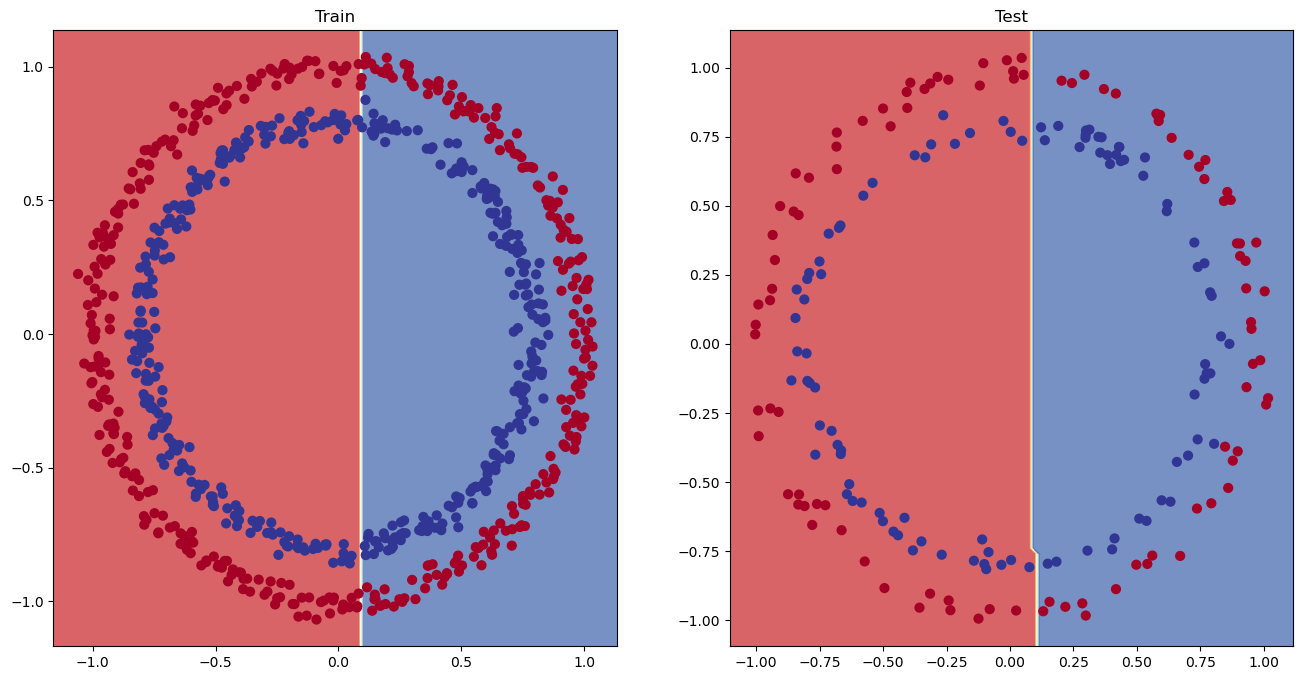

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [28]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self,x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69396 | Acc: 50.88 | Test Loss: 0.69261 | Test Acc: 51.00
Epoch: 100 | Loss: 0.69305 | Acc: 50.38 | Test Loss: 0.69379 | Test Acc: 48.00
Epoch: 200 | Loss: 0.69299 | Acc: 51.12 | Test Loss: 0.69437 | Test Acc: 46.00
Epoch: 300 | Loss: 0.69298 | Acc: 51.62 | Test Loss: 0.69458 | Test Acc: 45.00
Epoch: 400 | Loss: 0.69298 | Acc: 51.12 | Test Loss: 0.69465 | Test Acc: 46.00
Epoch: 500 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69467 | Test Acc: 46.00
Epoch: 600 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00
Epoch: 700 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00
Epoch: 800 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00
Epoch: 900 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00


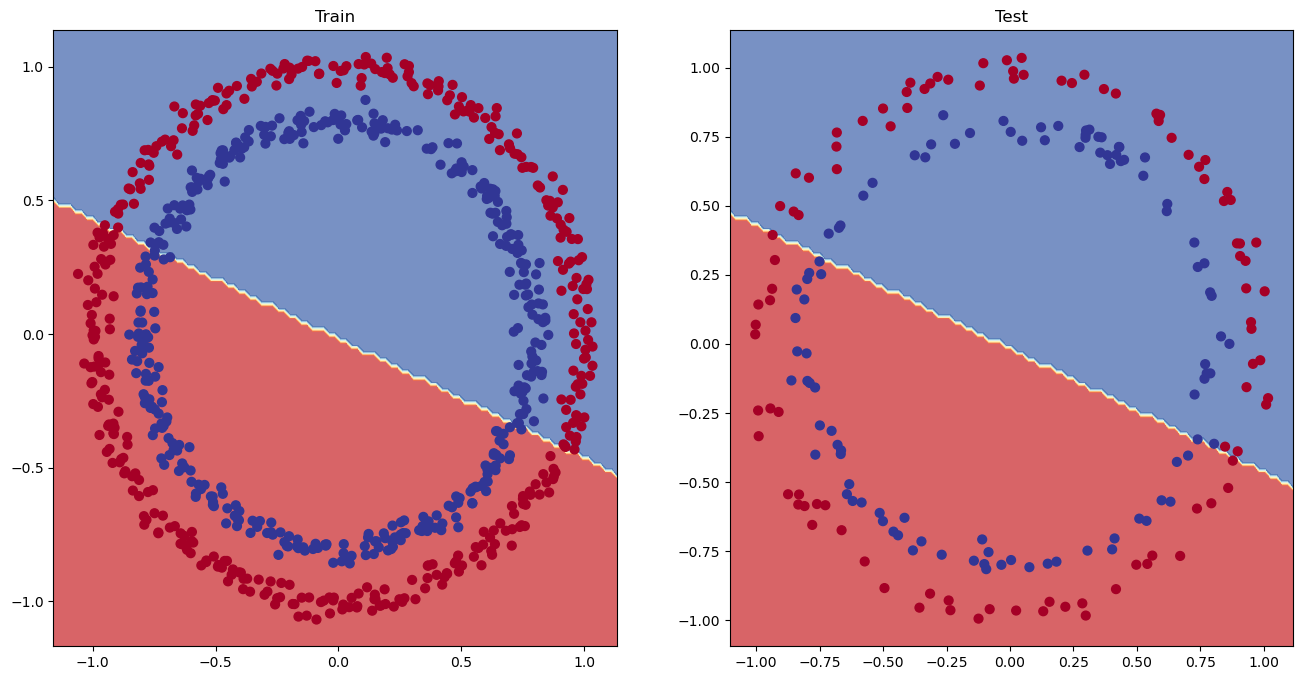

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [32]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))
    
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [33]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch = 1000

for epoch in range(epochs):
    model_2.train()
    
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69833 | Acc: 50.00 | Test Loss: 0.69863 | Test Acc: 49.00
Epoch: 100 | Loss: 0.69289 | Acc: 50.88 | Test Loss: 0.69411 | Test Acc: 47.00
Epoch: 200 | Loss: 0.69015 | Acc: 53.37 | Test Loss: 0.69141 | Test Acc: 50.00
Epoch: 300 | Loss: 0.68762 | Acc: 56.62 | Test Loss: 0.68828 | Test Acc: 55.00
Epoch: 400 | Loss: 0.68469 | Acc: 60.00 | Test Loss: 0.68469 | Test Acc: 61.00
Epoch: 500 | Loss: 0.67985 | Acc: 56.00 | Test Loss: 0.67890 | Test Acc: 60.50
Epoch: 600 | Loss: 0.67280 | Acc: 56.00 | Test Loss: 0.67176 | Test Acc: 60.50
Epoch: 700 | Loss: 0.66304 | Acc: 64.50 | Test Loss: 0.66452 | Test Acc: 65.00
Epoch: 800 | Loss: 0.64710 | Acc: 74.12 | Test Loss: 0.65300 | Test Acc: 71.50
Epoch: 900 | Loss: 0.62182 | Acc: 81.62 | Test Loss: 0.63241 | Test Acc: 78.00


In [35]:
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()


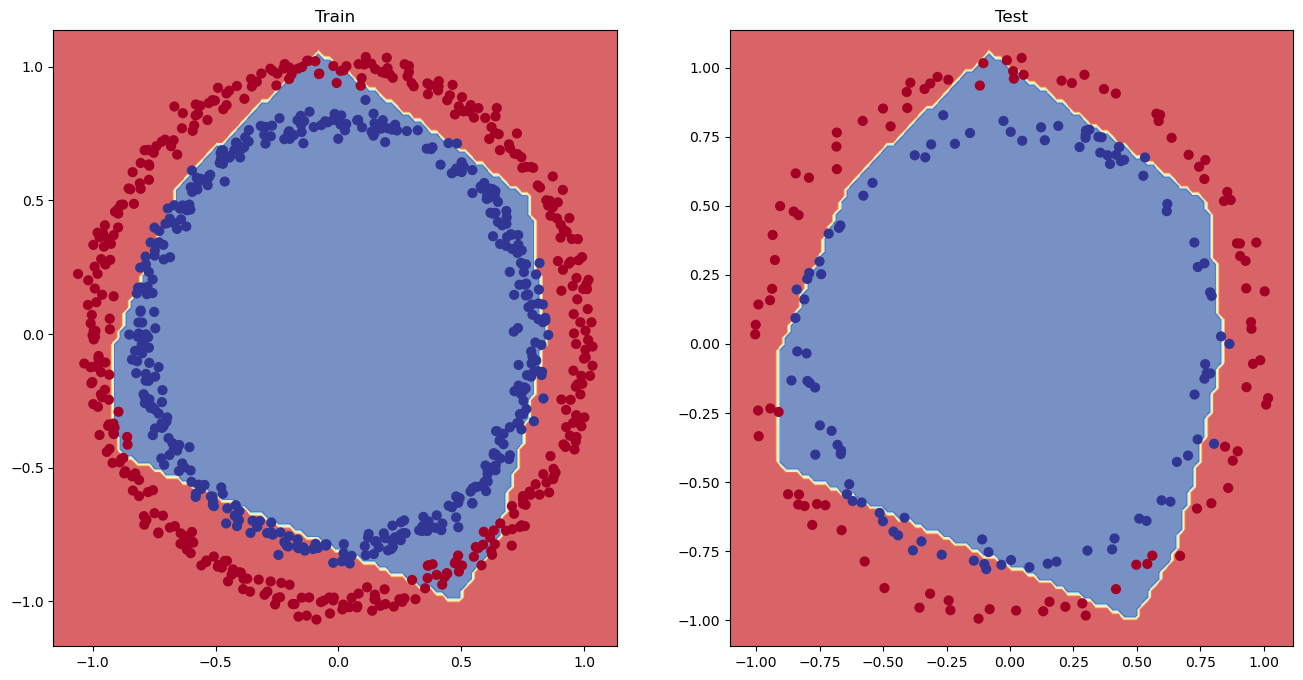

In [36]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

# Multiclass Dataset

In [37]:
from sklearn.datasets import make_blobs

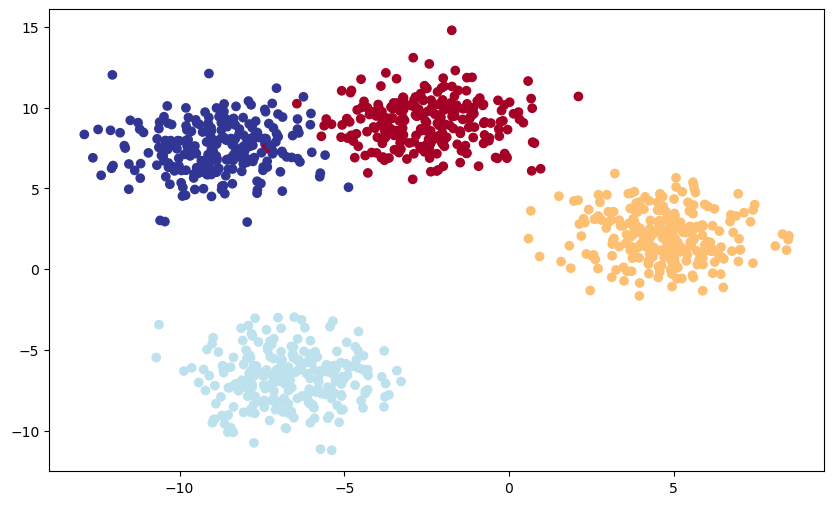

In [38]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std= 1.5, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)

plt.figure(figsize=(10,6))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)



In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [40]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), 
            nn.Linear(in_features=hidden_units, out_features=output_features)            
        )
        
    def forward(self,x):
        return self.linear_layer_stack(x)
    
model_3 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [41]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [42]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_blob_test.to(device)).squeeze()

In [43]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])

In [44]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [45]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device).type(torch.LongTensor)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device).type(torch.LongTensor)

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


In [47]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_blob_test)
    
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [48]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1955e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2377e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]])

In [49]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

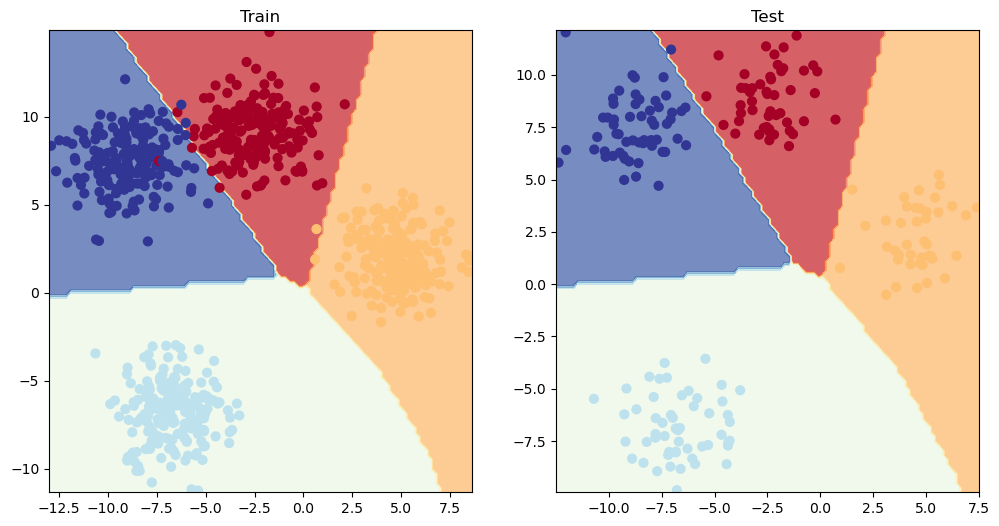

In [50]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)

In [53]:
import torchmetrics
from torchmetrics import Accuracy

In [56]:
torchmetrics_accuracy = Accuracy().to(device)

torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)